Dev notebook
============

In [50]:
import numpy as np
from numpy import ma
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

from skimage.util import montage
from skimage.filters import rank
from skimage import morphology
from skimage import exposure
from skimage import measure
from skimage import filters
from skimage import io
from skimage import data, draw
from skimage.registration import phase_cross_correlation
from skimage import transform
from skimage.registration import optical_flow_tvl1, optical_flow_ilk

from scipy import ndimage as ndi
from scipy import signal
from scipy import stats
from scipy import optimize

from dipy.align.transforms import AffineTransform2D
from dipy.align.imaffine import AffineRegistration

import cv2

from domb.reg_type import wf_x2_m2 as wf
from domb.fret.e_fret.e_app import Eapp
from domb.red_green import wt_vs_mut_multistim
from domb.utils import plot
from domb.utils.plot import CMaps
from domb.utils import masking

# Ionophoresis

## Amp vs. I

In [101]:
roi_max_mean = np.array([0.9097, 0.5054, 0.2749, 0.1612])
roi_max_sd = np.array([0.0980, 0.0514, 0.0306, 0.0251])

roi_med_up_mean = np.array([1.1911, 0.6726, 0.3473, 0.2299])
roi_med_up_sd = np.array([0.1378, 0.0562, 0.0126, 0.0157])

roi_med_down_mean = np.array([0.7803, 0.426, 0.2635, 0.12])
roi_med_down_sd = np.array([0.0716, 0.0582, 0.022, 0.0108])

roi_min_up_mean = np.array([1.0856, 0.6738, 0.3849, 0.2266])
roi_min_up_sd = np.array([0.0394, 0.0408, 0.0225, 0.0135])

roi_min_down_mean = np.array([0.4002, 0.2883, 0.1389, 0.0842])
roi_min_down_sd = np.array([0.0248, 0.0348, 0.0122, 0.0194])

curr_list = np.array([-100.0, -75.0, -50.0, -25.0])

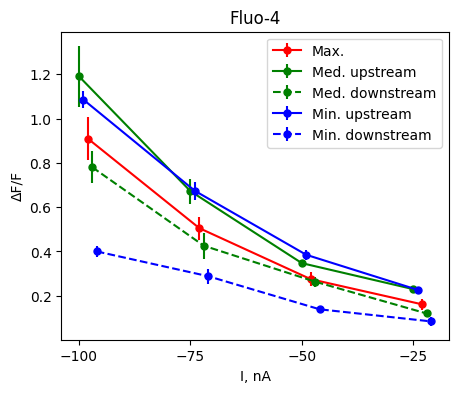

In [102]:
fig, ax = plt.subplots(figsize=(5,4))

ax.errorbar(x=curr_list+2, y=roi_max_mean,
            yerr=roi_max_sd, label='Max.',
            marker='.', markersize=10, color='red')
ax.errorbar(x=curr_list, y=roi_med_up_mean,
            yerr=roi_med_up_sd, label='Med. upstream',
            marker='.', markersize=10, color='green')
ax.errorbar(x=curr_list+3, y=roi_med_down_mean,
            yerr=roi_med_down_sd, label='Med. downstream',
            marker='.', markersize=10, color='green', linestyle='--')
ax.errorbar(x=curr_list+1, y=roi_min_up_mean,
            yerr=roi_min_up_sd, label='Min. upstream',
            marker='.', markersize=10, color='blue')
ax.errorbar(x=curr_list+4, y=roi_min_down_mean,
            yerr=roi_min_down_sd, label='Min. downstream',
            marker='.', markersize=10, color='blue', linestyle='--')

plt.title('Fluo-4')
plt.xlabel('I, nA')
plt.ylabel('ΔF/F')
plt.xticks(curr_list)
plt.legend()

fig.savefig('fluo_i.png', dpi=300)

In [104]:
roi_alexa_max_mean = np.array([8.8423, 4.1918, 2.1499, 1.6516])
roi_alexa_max_sd = np.array([1.6382, 0.4194, 0.2051, 0.1299])

roi_alexa_med_up_mean = np.array([4.3555, 2.492, 1.3466, 0.9786])
roi_alexa_med_up_sd = np.array([0.257, 0.1158, 0.0555, 0.049])

roi_alexa_med_down_mean = np.array([4.6075, 2.6625, 1.4303, 1.0975])
roi_alexa_med_down_sd = np.array([0.247, 0.0829, 0.054, 0.06])

roi_alexa_min_up_mean = np.array([3.0491, 2.0017, 1.0963, 0.813])
roi_alexa_min_up_sd = np.array([0.2677, 0.2007, 0.0882, 0.07])

roi_alexa_min_down_mean = np.array([1.9222, 1.3469, 0.7488, 0.5483])
roi_alexa_min_down_sd = np.array([0.142, 0.1185, 0.047, 0.048])

curr_list = np.array([-100.0, -75.0, -50.0, -25.0])

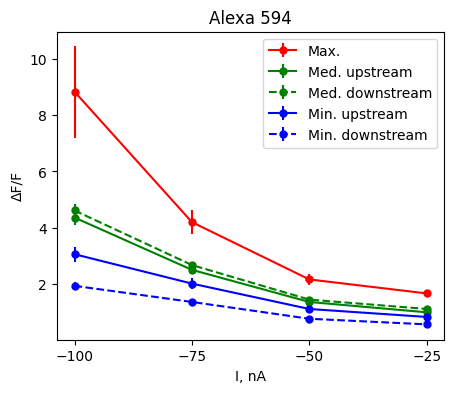

In [105]:
fig, ax = plt.subplots(figsize=(5,4))

ax.errorbar(x=curr_list, y=roi_alexa_max_mean,
            yerr=roi_alexa_max_sd, label='Max.',
            marker='.', markersize=10, color='red')
ax.errorbar(x=curr_list, y=roi_alexa_med_up_mean,
            yerr=roi_alexa_med_up_sd, label='Med. upstream',
            marker='.', markersize=10, color='green')
ax.errorbar(x=curr_list, y=roi_alexa_med_down_mean,
            yerr=roi_alexa_med_down_sd, label='Med. downstream',
            marker='.', markersize=10, color='green', linestyle='--')
ax.errorbar(x=curr_list, y=roi_alexa_min_up_mean,
            yerr=roi_alexa_min_up_sd, label='Min. upstream',
            marker='.', markersize=10, color='blue')
ax.errorbar(x=curr_list, y=roi_alexa_min_down_mean,
            yerr=roi_alexa_min_down_sd, label='Min. downstream',
            marker='.', markersize=10, color='blue', linestyle='--')

plt.title('Alexa 594')
plt.xlabel('I, nA')
plt.ylabel('ΔF/F')
plt.xticks(curr_list)
plt.legend()

fig.savefig('alexa_i.png', dpi=300)

## Spatial profiles

In [2]:
raw_img = io.imread('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/24_05_9_cell01.tif')
cell_mask = io.imread('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/24_05_9_cell01_0-60_ch0_red-green_up-labels.tif')
cell_mask.shape

(1040, 1392)

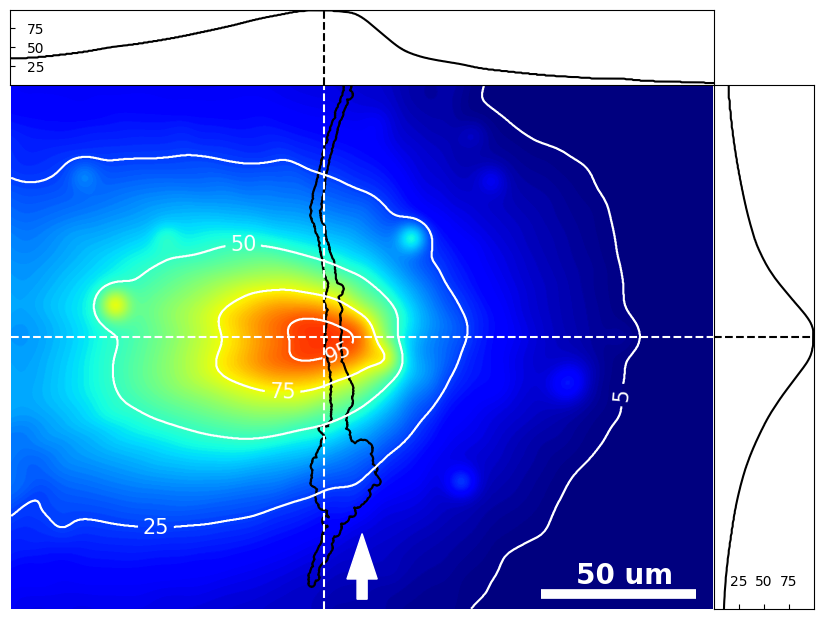

In [227]:
alexa_avg_max_img = np.max(raw_img[20:26,1,...], axis=0)
alexa_filtered = filters.gaussian(alexa_avg_max_img, sigma=20)
alexa_norm = (alexa_filtered - np.min(alexa_filtered)) / (np.max(alexa_filtered) - np.min(alexa_filtered))

alexa_norm = np.asarray(alexa_norm * 100, dtype=np.int8)
alexa_bin = np.digitize(alexa_norm, bins=[0, 5, 25, 50, 75, 95])

fig = plt.figure(figsize=(8.05, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 1), height_ratios=(1, 7),
                      left=0.001, right=1, bottom=0.001, top=1,
                      wspace=0, hspace=0)
ax = fig.add_subplot(gs[1, 0])
ax.imshow(alexa_norm, cmap='jet', vmin=5, vmax=115)
ax.contour(cell_mask, levels=[0], colors='k')
ax.axvline(x=620, color='w', linestyle='--')
ax.axhline(y=500, color='w', linestyle='--')
cs = ax.contour(alexa_norm, 
                levels=[5, 25, 50, 75, 95], colors='w')
ax.clabel(cs, inline=True, fontsize=15)
ax.set_axis_off()

ax.text(x=1120,y=990,s='50 um', color='w', size=20, weight='bold')
ax.arrow(x=696, y=1020, dx=0, dy=-40, color='w', width=20)
ax.hlines(y=1010, xmin=1050, xmax=1358, linewidth=7, color='w')

ax_profx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_profx.plot(np.mean(alexa_norm[490:511,:], axis=0), color='k')
ax_profx.axvline(x=620, color='k', linestyle='--')
ax_profx.set_xticks([])
ax_profx.set_yticks([25, 50, 75])
ax_profx.set_ylim(0, 100)
ax_profx.tick_params(axis="y",direction="in", pad=-25)

ax_profy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_profy.plot(np.mean(alexa_norm[:,610:631], axis=1), np.arange(0, alexa_norm.shape[0],1), color='k')
ax_profy.axhline(y=500, color='k', linestyle='--')
ax_profy.set_yticks([])
ax_profy.set_xticks([25, 50, 75])
ax_profy.set_xlim(0, 100)
ax_profy.tick_params(axis="x",direction="in", pad=-25)

fig.savefig('alexa_map.png', dpi=300)

In [170]:
norm = lambda a,max,min: (a-min)/(max-min)

prof_100 = np.flip(np.mean(np.max(raw_img[20:26, 1, ...], axis=0)[:,610:631], axis=1))
norm_100 = norm(prof_100, np.max(prof_100), np.min(prof_100))
prof_75 = np.flip(np.mean(np.max(raw_img[80:85, 1, ...], axis=0)[:,610:631], axis=1) )
norm_75 = norm(prof_75, np.max(prof_100), np.min(prof_100))
prof_50 = np.flip(np.mean(np.max(raw_img[140:145, 1, ...], axis=0)[:,610:631], axis=1))
norm_50 = norm(prof_50, np.max(prof_100), np.min(prof_100))
prof_25 = np.flip(np.mean(np.max(raw_img[200:204, 1, ...], axis=0)[:,610:631], axis=1))
norm_25 = norm(prof_25, np.max(prof_100), np.min(prof_100))

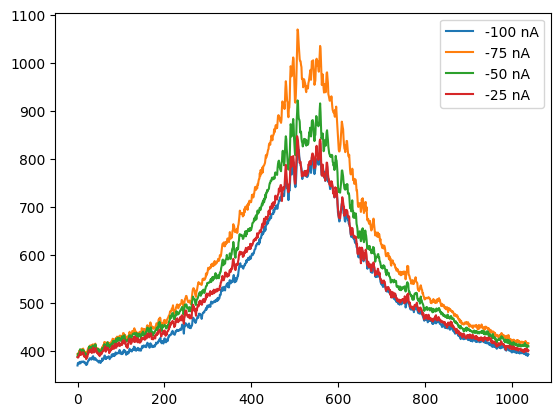

In [171]:
plt.plot(prof_100, label='-100 nA')
plt.plot(prof_75, label='-75 nA')
plt.plot(prof_50, label='-50 nA')
plt.plot(prof_25, label='-25 nA')
plt.legend()

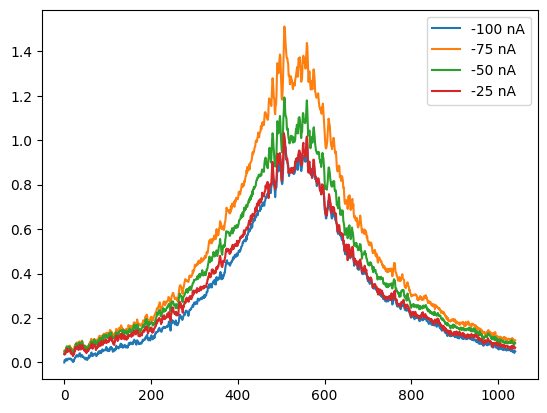

In [173]:
plt.plot(norm_100, label='-100 nA')
plt.plot(norm_75, label='-75 nA')
plt.plot(norm_50, label='-50 nA')
plt.plot(norm_25, label='-25 nA')
plt.legend()

## Temporal profile

### -100 nA

In [44]:
def df_to_stat(path, norm=False):
    df = pd.read_csv(path)
    arr = np.asarray(df.groupby('roi').int.apply(np.array).reset_index()['int'])
    arr = np.array([row for row in arr])
    if norm:
        arr_norm = (arr - np.min(arr))/(np.max(arr) - np.min(arr))
        return np.stack((np.mean(arr_norm, axis=0), np.std(arr_norm, axis=0)), axis=0)
    else:
        return np.stack((np.mean(arr, axis=0), np.std(arr, axis=0)), axis=0)

fluo_max = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_1_zone max.csv')
fluo_med_up = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_1_zone med up.csv')
fluo_med_down = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_1_zone med down.csv')
fluo_min_up = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_1_zone min up.csv')
fluo_min_down = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_1_zone min down.csv')

alexa_max = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_1_alexa_max.csv')
alexa_med_up = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_1_alexa_med_up.csv')
alexa_med_down = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_1_alexa_med_down.csv')
alexa_min_up = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_1_alexa_min_up.csv')
alexa_min_down = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_1_alexa_min_down.csv')

time_line = np.arange(0,60,1)

### -25 nA

In [229]:
# def df_to_stat(path, norm=False):
#     df = pd.read_csv(path)
#     arr = np.asarray(df.groupby('roi').int.apply(np.array).reset_index()['int'])
#     arr = np.array([row for row in arr])
#     if norm:
#         arr_norm = (arr - np.min(arr))/(np.max(arr) - np.min(arr))
#         return np.stack((np.mean(arr_norm, axis=0), np.std(arr_norm, axis=0)), axis=0)
#     else:
#         return np.stack((np.mean(arr, axis=0), np.std(arr, axis=0)), axis=0)

# fluo_max = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_4_zone max.csv')
# fluo_med_up = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_4_zone med up.csv')
# fluo_med_down = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_4_zone med down.csv')
# fluo_min_up = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_4_zone min up.csv')
# fluo_min_down = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_4_zone min down.csv')

# alexa_max = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_4_alexa_max.csv')
# alexa_med_up = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_4_alexa_med_up.csv')
# alexa_med_down = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_4_alexa_med_down.csv')
# alexa_min_up = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_4_alexa_min_up.csv')
# alexa_min_down = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_4_alexa_min_down.csv')

# time_line = np.arange(0,60,1)

### Plot

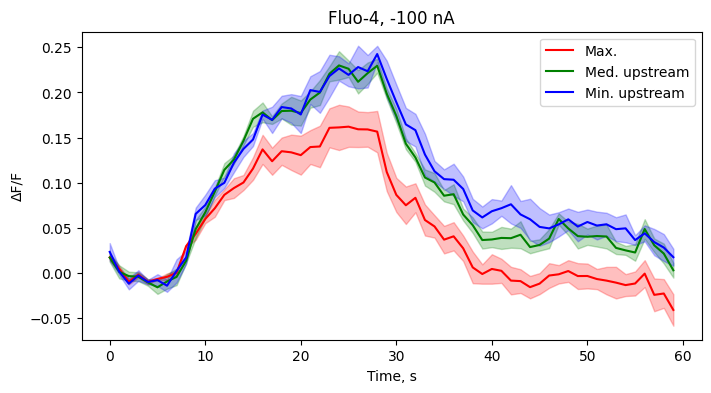

In [232]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(time_line, fluo_max[0], color='red', label='Max.')
ax.fill_between(x=time_line, y1=fluo_max[0]+fluo_max[1], y2=fluo_max[0]-fluo_max[1],
                 alpha=.25, color='red')
ax.plot(time_line, fluo_med_up[0], color='green', label='Med. upstream')
ax.fill_between(x=time_line, y1=fluo_med_up[0]+fluo_med_up[1], y2=fluo_med_up[0]-fluo_med_up[1],
                 alpha=.25, color='green')
ax.plot(time_line, fluo_min_up[0], color='blue', label='Min. upstream')
ax.fill_between(x=time_line, y1=fluo_min_up[0]+fluo_min_up[1], y2=fluo_min_up[0]-fluo_min_up[1],
                 alpha=.25, color='blue')
ax.hlines(y=1.4, xmin=5.5, xmax=25, color='k', linewidth=3)

axins = ax.inset_axes([0.27, 0.1, 0.2, 0.3])
axins.plot(time_line, fluo_max[0], color='red', label='Max.', marker='.')
axins.fill_between(x=time_line, y1=fluo_max[0]+fluo_max[1], y2=fluo_max[0]-fluo_max[1],
                   alpha=.25, color='red')
axins.plot(time_line, fluo_med_up[0], color='green', label='Med. upstream', marker='.')
axins.fill_between(x=time_line, y1=fluo_med_up[0]+fluo_med_up[1], y2=fluo_med_up[0]-fluo_med_up[1],
                 alpha=.25, color='green')
axins.plot(time_line, fluo_min_up[0], color='blue', label='Min. upstream', marker='.')
axins.fill_between(x=time_line, y1=fluo_min_up[0]+fluo_min_up[1], y2=fluo_min_up[0]-fluo_min_up[1],
                 alpha=.25, color='blue')
x1, x2, y1, y2 = 3, 10, -0.025, 0.4
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
# axins.set_yticks([])

axins2 = ax.inset_axes([0.58, 0.5, 0.2, 0.3])
axins2.plot(time_line, fluo_max[0], color='red', label='Max.', marker='.')
axins2.fill_between(x=time_line, y1=fluo_max[0]+fluo_max[1], y2=fluo_max[0]-fluo_max[1],
                   alpha=.25, color='red')
axins2.plot(time_line, fluo_med_up[0], color='green', label='Med. upstream', marker='.')
axins2.fill_between(x=time_line, y1=fluo_med_up[0]+fluo_med_up[1], y2=fluo_med_up[0]-fluo_med_up[1],
                 alpha=.25, color='green')
axins2.plot(time_line, fluo_min_up[0], color='blue', label='Min. upstream', marker='.')
axins2.fill_between(x=time_line, y1=fluo_min_up[0]+fluo_min_up[1], y2=fluo_min_up[0]-fluo_min_up[1],
                 alpha=.25, color='blue')
x1, x2, y1, y2 = 24, 30, 0.5, 1.35
axins2.set_xlim(x1, x2)
axins2.set_ylim(y1, y2)

ax.indicate_inset_zoom(axins)
ax.indicate_inset_zoom(axins2)

plt.title('Fluo-4, -100 nA')
plt.xlabel('Time, s')
plt.ylabel('ΔF/F')
plt.legend(loc=1)

fig.savefig('fluo_prof.png', dpi=300)

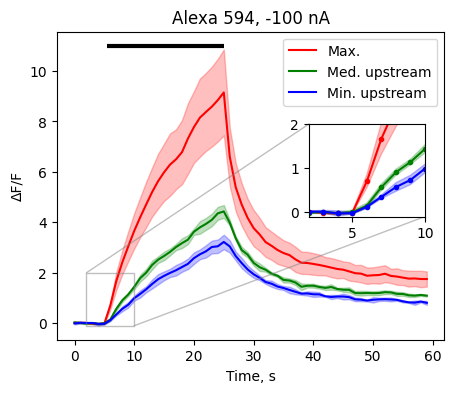

In [145]:
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(time_line, alexa_max[0], color='red', label='Max.')
ax.fill_between(x=time_line, y1=alexa_max[0]+alexa_max[1], y2=alexa_max[0]-alexa_max[1],
                 alpha=.25, color='red')
ax.plot(time_line, alexa_med_up[0], color='green', label='Med. upstream')
ax.fill_between(x=time_line, y1=alexa_med_up[0]+alexa_med_up[1], y2=alexa_med_up[0]-alexa_med_up[1],
                 alpha=.25, color='green')
ax.plot(time_line, alexa_min_up[0], color='blue', label='Min. upstream')
ax.fill_between(x=time_line, y1=alexa_min_up[0]+alexa_min_up[1], y2=alexa_min_up[0]-alexa_min_up[1],
                 alpha=.25, color='blue')
ax.hlines(y=11, xmin=5.5, xmax=25, color='k', linewidth=3)

axins = ax.inset_axes([0.65, 0.4, 0.3, 0.3])
axins.plot(time_line, alexa_max[0], color='red', label='Max.', marker='.')
axins.fill_between(x=time_line, y1=alexa_max[0]+alexa_max[1], y2=alexa_max[0]-alexa_max[1],
                   alpha=.25, color='red')
axins.plot(time_line, alexa_med_up[0], color='green', label='Med. upstream', marker='.')
axins.fill_between(x=time_line, y1=alexa_med_up[0]+alexa_med_up[1], y2=alexa_med_up[0]-alexa_med_up[1],
                 alpha=.25, color='green')
axins.plot(time_line, alexa_min_up[0], color='blue', label='Min. upstream', marker='.')
axins.fill_between(x=time_line, y1=alexa_min_up[0]+alexa_min_up[1], y2=alexa_min_up[0]-alexa_min_up[1],
                 alpha=.25, color='blue')
x1, x2, y1, y2 = 2, 10, -0.1, 2
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
# axins.set_yticks([])

ax.indicate_inset_zoom(axins)

plt.title('Alexa 594, -100 nA')
plt.xlabel('Time, s')
plt.ylabel('ΔF/F')
plt.legend()

fig.savefig('alexa_prof.png', dpi=300)

### -25 nA

# Files merging

In [41]:
img_1 = io.imread('/home/wisstock/bio_data/chemLTD/Sasha/24_05_09/24_05_9_cell08_p1.tif')
img_2 = io.imread('/home/wisstock/bio_data/chemLTD/Sasha/24_05_09/24_05_9_cell08_p2.tif')
img_3 = io.imread('/home/wisstock/bio_data/chemLTD/Sasha/24_05_09/24_05_9_cell08_p3.tif')

print(img_1.shape)
print(img_2.shape)
print(img_3.shape)

<tifffile.TiffFile '24_05_9_cell08_p1.tif'> OME series is missing 757 frames. Missing data are zeroed


<tifffile.TiffFile '24_05_9_cell08_p2.tif'> OME series is missing 74 frames. Missing data are zeroed


(720, 2, 1040, 1392)
(720, 2, 1040, 1392)
(720, 2, 1040, 1392)


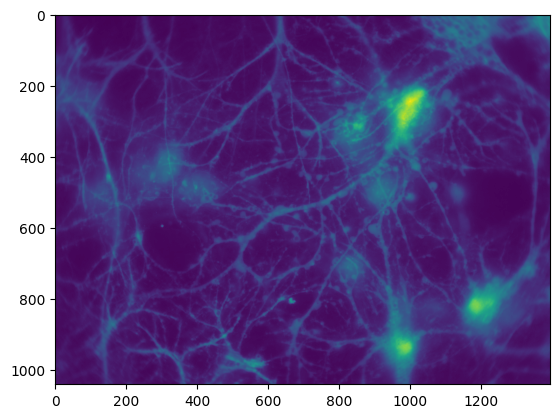

In [42]:
img_1_crop = img_1[:342,...]
plt.imshow(img_1_crop[-1,0,...])

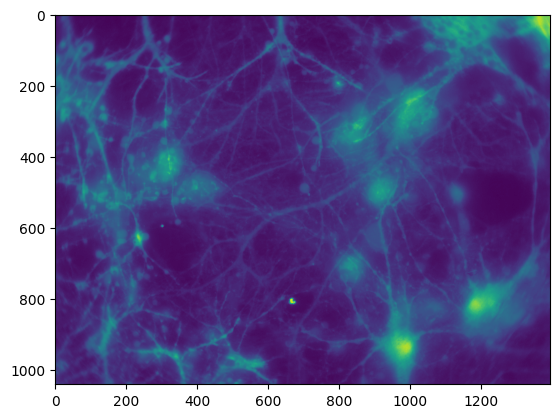

In [43]:
img_2_crop = img_2[342:683,...]
plt.imshow(img_2_crop[-1,0,...])

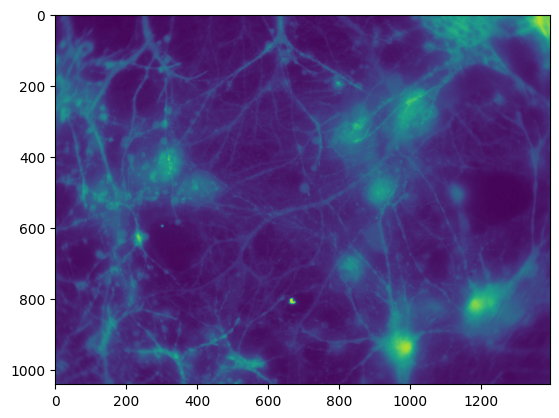

In [44]:
img_3_crop = img_3[683:,...]
plt.imshow(img_3_crop[0,0,...])

In [45]:
img_out = np.concatenate((img_1_crop, img_2_crop, img_3_crop), axis=0)
print(img_out.shape)

io.imsave('/home/wisstock/bio_data/chemLTD/Sasha/24_05_09/24_05_9_cell08.tif', img_out)

(720, 2, 1040, 1392)


# GFAP masking

In [11]:
img = io.imread('/home/wisstock/bio_data/GLT_NeuN/astro/3D_TBI_GFAP_GLT1/3D_TBI_GFAP_GLT1_18.tif')
print(img.shape)

(2, 10, 1200, 1600)


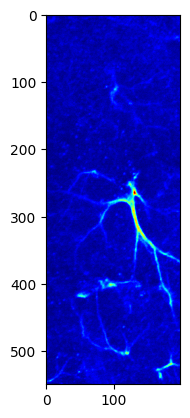

In [19]:
gfap = np.mean(img[1], axis=0)

bc_p = lambda x: np.array([f - np.percentile(f, 0.5) for f in x]).clip(min=0).astype(dtype=x.dtype)
gfap = bc_p(gfap)
gfap = gfap[250:800, 0:200].astype(np.uint16)

plt.imshow(gfap, cmap='jet')

In [20]:
gfap.dtype

dtype('uint16')

/home/wisstock/anaconda3/envs/domb/lib/python3.9/site-packages/skimage/filters/rank/generic.py:268: UserWarning: Bad rank filter performance is expected due to a large number of bins (1826), equivalent to an approximate bitdepth of 10.8.
  image, footprint, out, mask, n_bins = _preprocess_input(image, footprint,


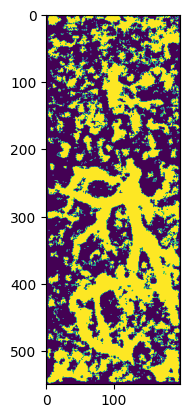

In [29]:
gfap_entropy = rank.entropy(gfap, morphology.disk(5))
plt.imshow(gfap_entropy, cmap='jet')

raw_mask = gfap > filters.threshold_otsu(gfap)
ent_mask = gfap_entropy > filters.threshold_otsu(gfap_entropy)

plt.imshow(ent_mask)

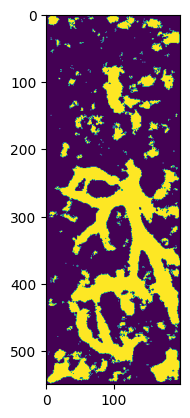

# WF x2 m2 uploading

In [ ]:
reg_path = 'data/wt_vs_mut/23_10_27_01.tif'
# reg_path = 'data/wt_vs_mut/23_06_23_11.tif'
reg_name = reg_path.split('/')[-1]
reg_name = reg_name.split('.')[0]

# fp1-CFP(1), fp2-YFP(3) or fp1-RFP(3), fp2-YFP(0)
reg = wf(img_path=reg_path, img_name=reg_name, ch_order={'fp1':3,'fp2':0}, gauss_sigma=.75, border_crop=20,  # regtype parameters
         proc_sigma=1.5, win_size=801, k_val=1e-5, r_val=0.5,    # processes masking parameters
         soma_mask=False, soma_th=.5, soma_ext=50,
         proc_ext=10,
         select_largest_mask=True)

reg.ch_pic()
reg.processes_mask_pic()

# Photobleaching correction with exponential fit

In [ ]:
def pb_exp_correction(input_img:np.ndarray, mask:np.ndarray):
    """ Image series photobleaching correction by exponential fit.
    
    Correction proceeds by masked area of interest, not the whole frame to prevent autofluorescence influence.

    Parameters
    ----------
    input_img: ndarray [t,x,y]
        input image series
    mask: ndarray [x,y]
        mask of region of interest, must be same size with image frames

    Returns
    -------
    corrected_img: ndarray [t,x,y]
        corrected image series
    r_val: float
        R-squared value of exponential fit

    """
    exp = lambda x,a,b: a * np.exp(-b * x)
    # bi_exp = lambda x,a,b,c,d: (a * np.exp(-b * x)) + (c * np.exp(-d * x))

    bleach_profile = np.mean(input_img, axis=(1,2), where=mask)
    x_profile = np.linspace(0, bleach_profile.shape[0], bleach_profile.shape[0])

    popt,_ = optimize.curve_fit(exp, x_profile, bleach_profile)
    bleach_fit = np.vectorize(exp)(x_profile, *popt)
    bleach_coefs =  bleach_fit / bleach_fit.max()
    bleach_coefs = bleach_coefs.reshape(-1, 1, 1)
    corrected_image = input_img/bleach_coefs

    _,_,r_val,_,_ = stats.linregress(bleach_profile, bleach_fit)

    return corrected_image, r_val


In [ ]:
int_curve = np.mean(reg.fp2_img_raw, axis=(1,2), where=reg.proc_mask)

print(int_curve.shape)

plt.figure(figsize=(12,5))
plt.plot(int_curve)
plt.show()

In [ ]:
corrected_img,_ = pb_exp_correction(input_img=reg.fp2_img_raw, mask=reg.proc_mask)
print(corrected_img)
corr_curve = np.mean(corrected_img, axis=(1,2), where=reg.proc_mask)

plt.figure(figsize=(12,5))
plt.plot(corr_curve)
plt.plot(int_curve, linestyle='--')
plt.show()

In [ ]:


exp = lambda x,a,b: a * np.exp(-b * x)
bi_exp = lambda x,a,b,c,d: (a * np.exp(-b * x)) + (c * np.exp(-d * x))

popt,_ = optimize.curve_fit(exp, x_line, int_curve)
print(popt)

bleach_fit = np.vectorize(exp)(x_line, *popt)

plt.figure(figsize=(12,5))
plt.plot(x_line, int_curve)
plt.plot(x_line, bleach_fit, linestyle='--')
plt.show()

In [ ]:
stats.linregress(int_curve, bleach_fit)

In [ ]:
bleach_coefs =  bleach_fit / bleach_fit.max()
bleach_coefs

In [ ]:
bleach_coefs = bleach_coefs.reshape(-1, 1, 1)
bleach_coefs.shape

In [ ]:
int_corr = np.mean(reg.fp2_img_raw/bleach_coefs, axis=(1,2), where=reg.proc_mask)

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(x_line, int_curve)
plt.plot(x_line, int_corr, linestyle=':')
plt.plot(x_line, bleach_fit, linestyle='--')
plt.show()

In [ ]:
def arr_cascade_plot(input_arr:np.ndarray, y_shift:float=0.1,
                     min_amp:float=0):
    plt.figure(figsize=(20, 8))
    
    shift = 0
    for num_ROI in range(input_arr.shape[0]):
        prof_ROI = input_arr[num_ROI]
        if prof_ROI.max() < min_amp:
            continue
        else:
            plt.plot(prof_ROI+shift, alpha=.85, label=f'ROI {num_ROI}')
            shift += y_shift

    # for line_name in line_dict:
    #     line_lim = line_dict[line_name]
    #     plt.plot(line_lim, [-0.4] * len(line_lim), label=line_name, linewidth=4)

    # plt.vlines(x=[-20], ymin=[-0.1], ymax=[0.0], linewidth=3, color='k')
    # plt.text(x=-30, y=-0.2, s="0.1", size=15, rotation=90.)

    # plt.hlines(y=[-0.75], xmin=[-2], xmax=[8], linewidth=3, color='k')
    # plt.text(x=30, y=-1.15, s="10 s", size=15)

    plt.axis('off')
    # plt.legend(loc=2)
    plt.show()


arr_cascade_plot(fp1_df_prof, y_shift=0.5, min_amp=0.1)

# Channels registration

In [2]:
def misalign_estimate(img1, img2, title:str=''):
    img1 = (img1 - img1.min()) / (img1.max()- img1.min()).astype(np.float32)
    img2 = (img2 - img2.min()) / (img2.max()- img2.min()).astype(np.float32)  

#     img1 = np.true_divide(img1, 65535, dtype=np.float32)
#     img2 = np.true_divide(img2, 65535, dtype=np.float32)

    v, u = optical_flow_tvl1(img1, img2)
    norm = np.sqrt(u ** 2 + v ** 2)

    nvec = 20  # Number of vectors to be displayed along each image dimension
    nl, nc = img1.shape
    step = max(nl//nvec, nc//nvec)

    y, x = np.mgrid[:nl:step, :nc:step]
    u_ = u[::step, ::step]
    v_ = v[::step, ::step]

    img_rgb = np.zeros((img1.shape[0], img1.shape[1], 3), dtype=np.float32)
    img_rgb[..., 0] = img1
    img_rgb[..., 1] = img2

    shift, error, diffphase = phase_cross_correlation(img1, img2, upsample_factor=500)

    fig, axes = plt.subplots(ncols=2, figsize=(15,10))
    ax = axes.ravel()
    ax[0].imshow(norm)
    ax[0].quiver(x, y, u_, v_, color='r', units='dots',
            angles='xy', scale_units='xy', lw=3)
    ax[1].imshow(img_rgb)
    fig.suptitle(title+f' shift {shift}, phase difference {diffphase:.2E}')
    fig.tight_layout()
    fig.show()

/tmp/ipykernel_16853/307508263.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


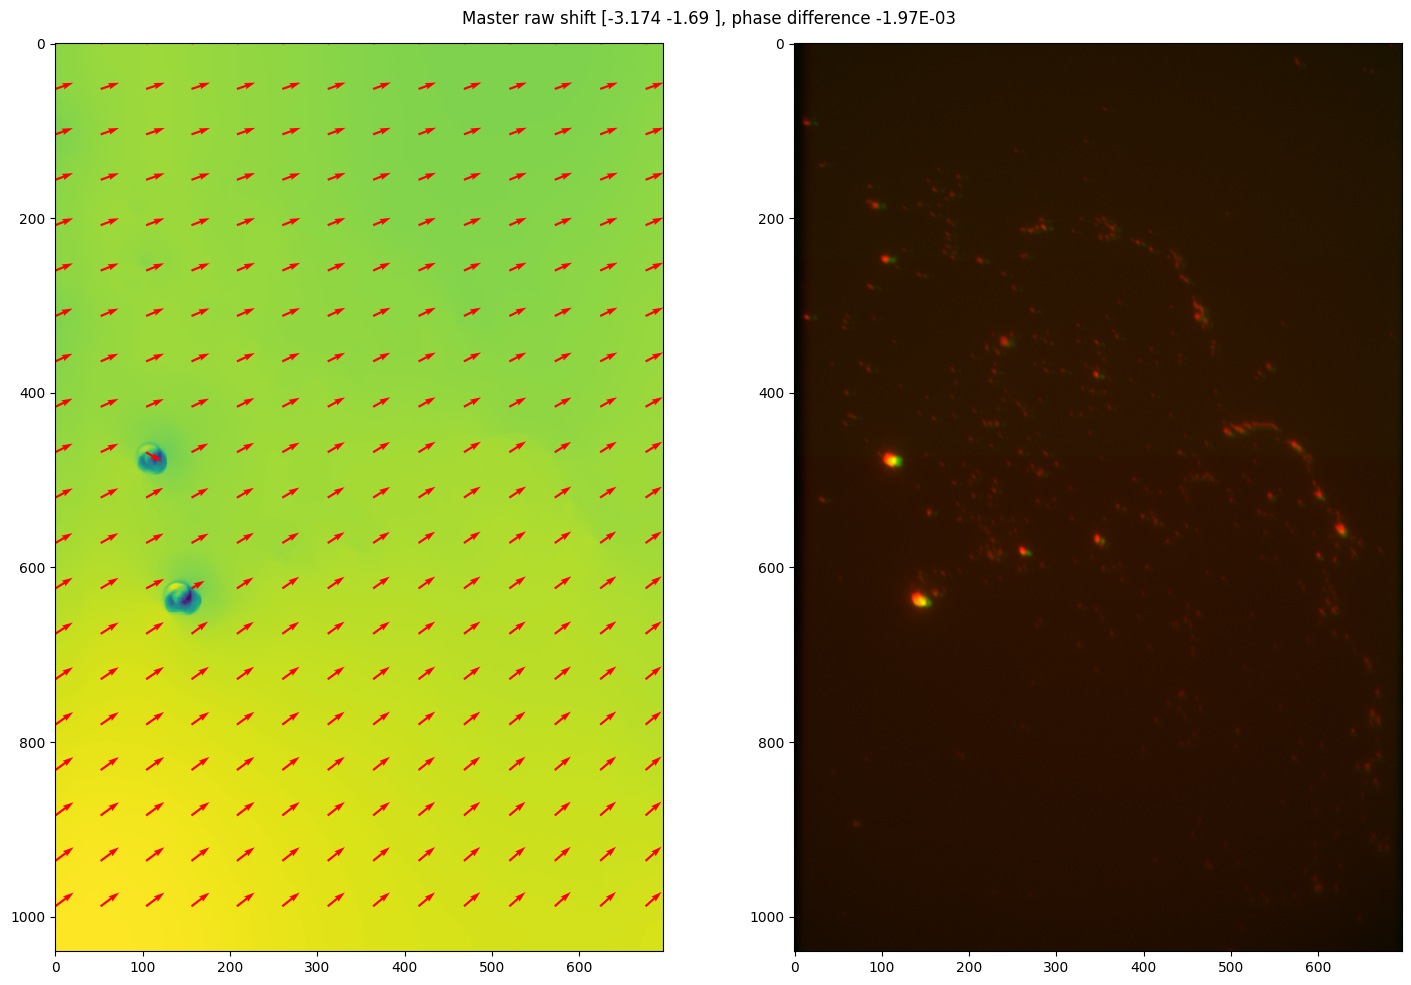

In [8]:
border_crop = 20

# correction img
raw_beads = io.imread('/home/wisstock/bio_data/chemLTD/24_03_8/drift/beads_01.tif')[0]
y,x = raw_beads.shape[1:3]
# raw_beads = raw_beads[:,border_crop:y-border_crop,border_crop:x-border_crop]
master_ref = raw_beads[1]
master_offset = raw_beads[0]

master_rgb = np.zeros((master_ref.shape[0], master_ref.shape[1], 3))
master_rgb[..., 0] = master_ref
master_rgb[..., 1] = master_offset

misalign_estimate(master_ref, master_offset, title='Master raw')

/tmp/ipykernel_16853/307508263.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(20, 1040, 696)

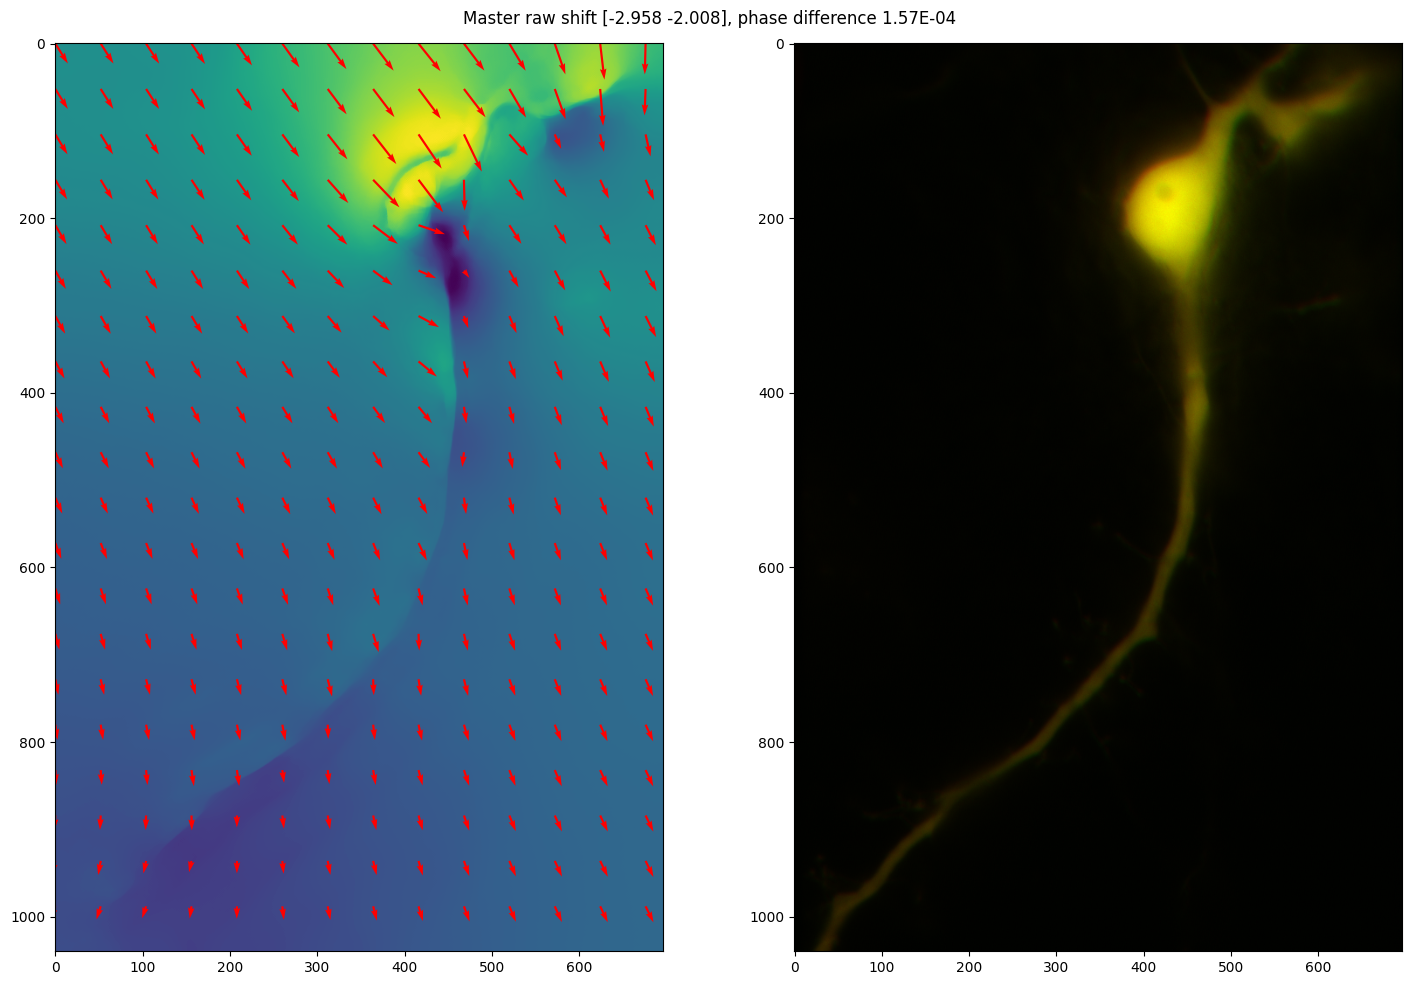

In [4]:

# demo img
demo_img = io.imread('/home/wisstock/bio_data/chemLTD/24_03_8/drift/24_03_8_tandem_04.tif')

demo_ref = demo_img[:,:,:,1]
demo_offset = demo_img[:,:,:,0]

misalign_estimate(demo_ref[0], demo_offset[0], title='Master raw')
demo_ref.shape

## DiPy

(980, 636) (980, 636)
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
(20, 1040, 696)
696 1040
636 980


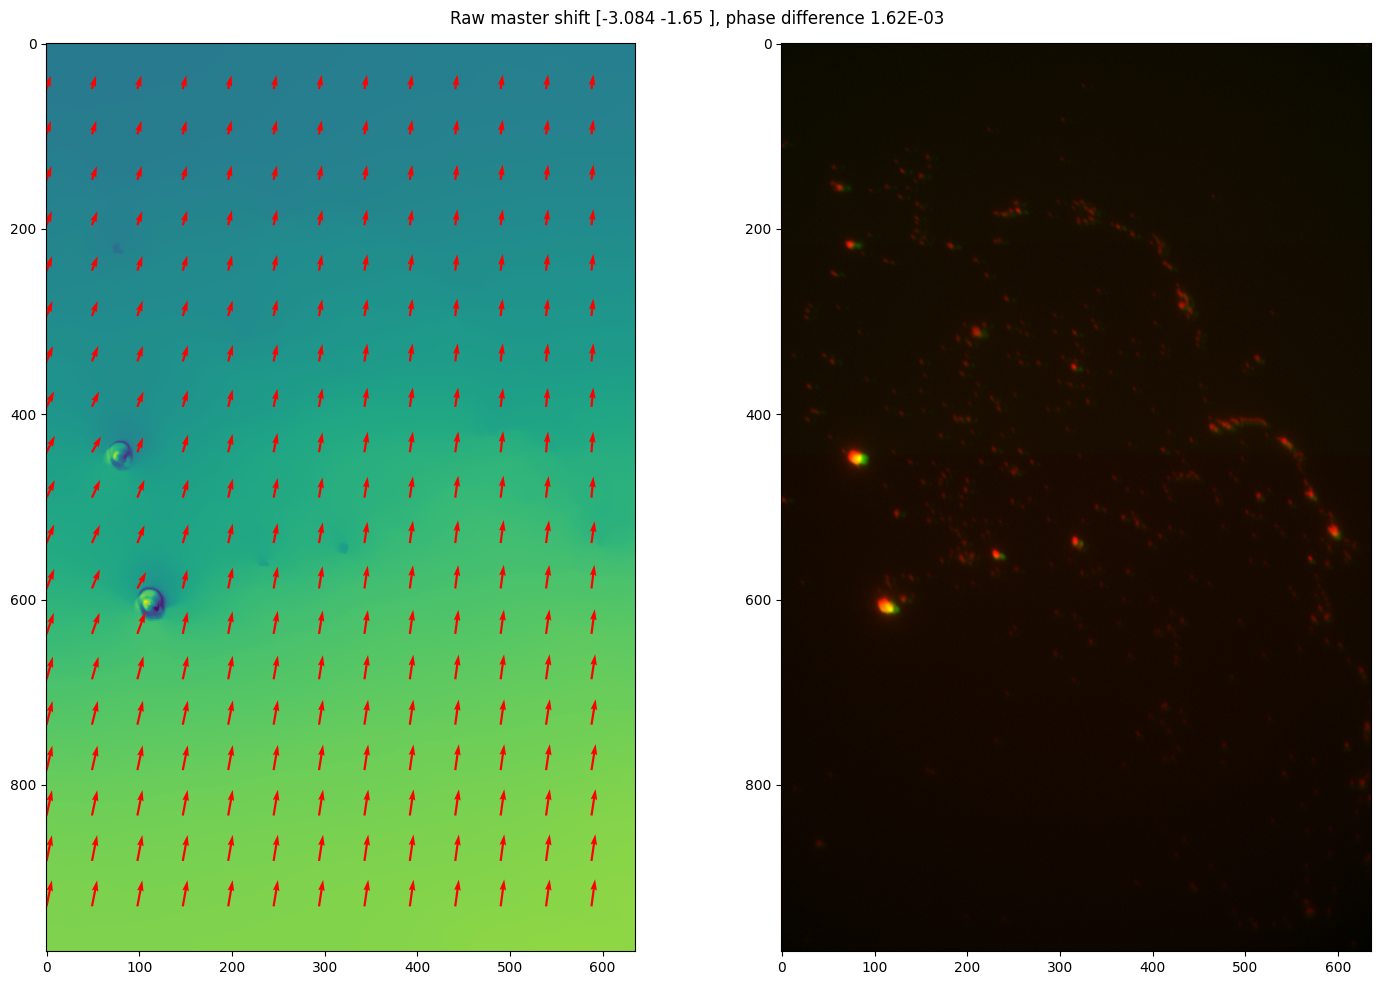

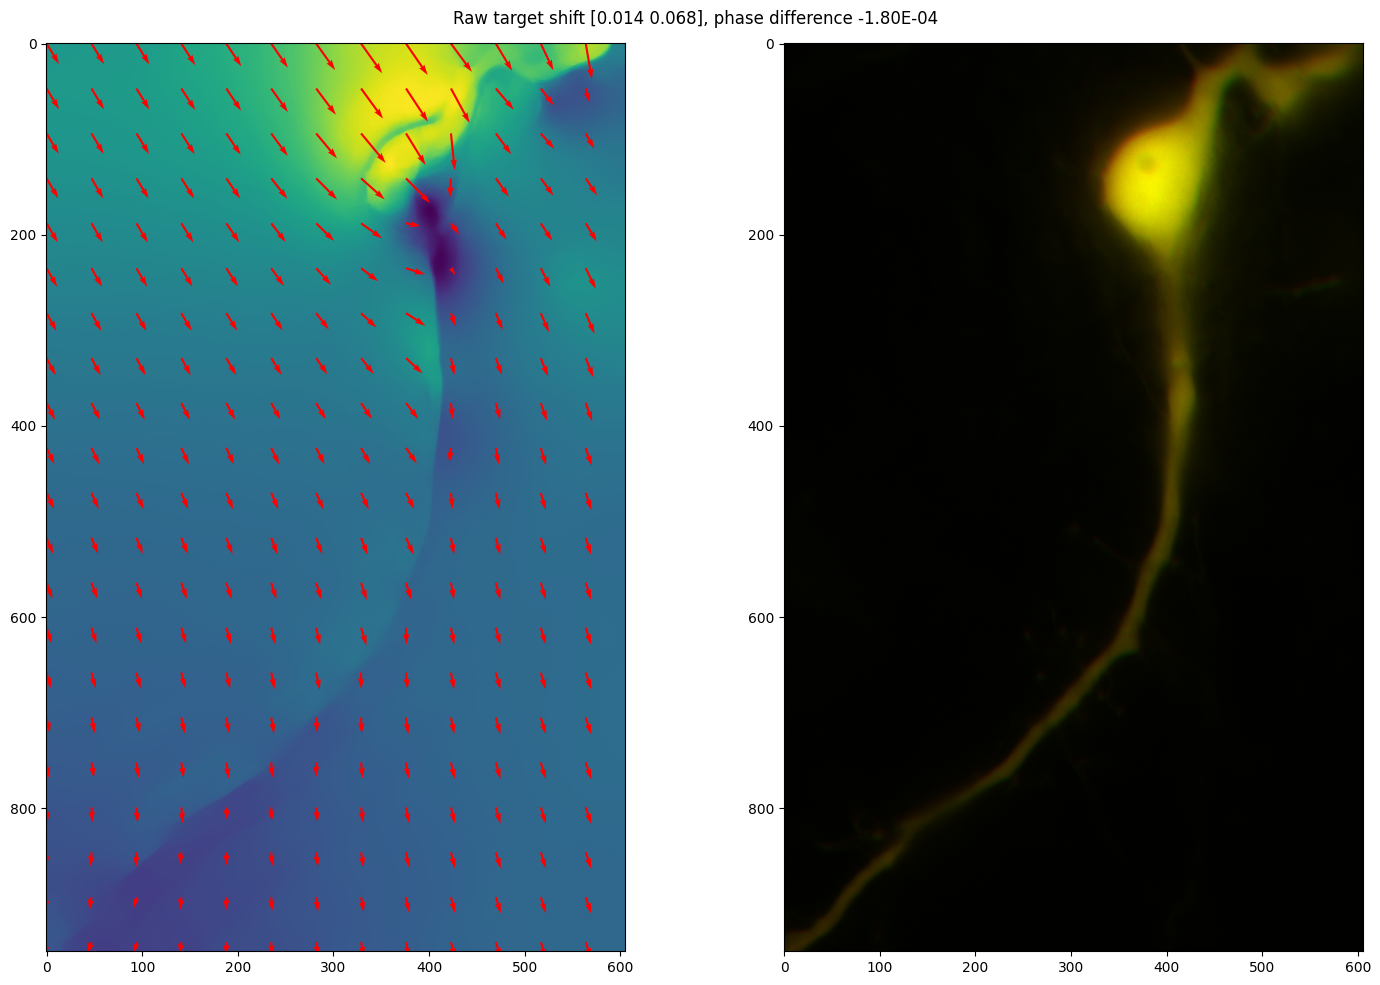

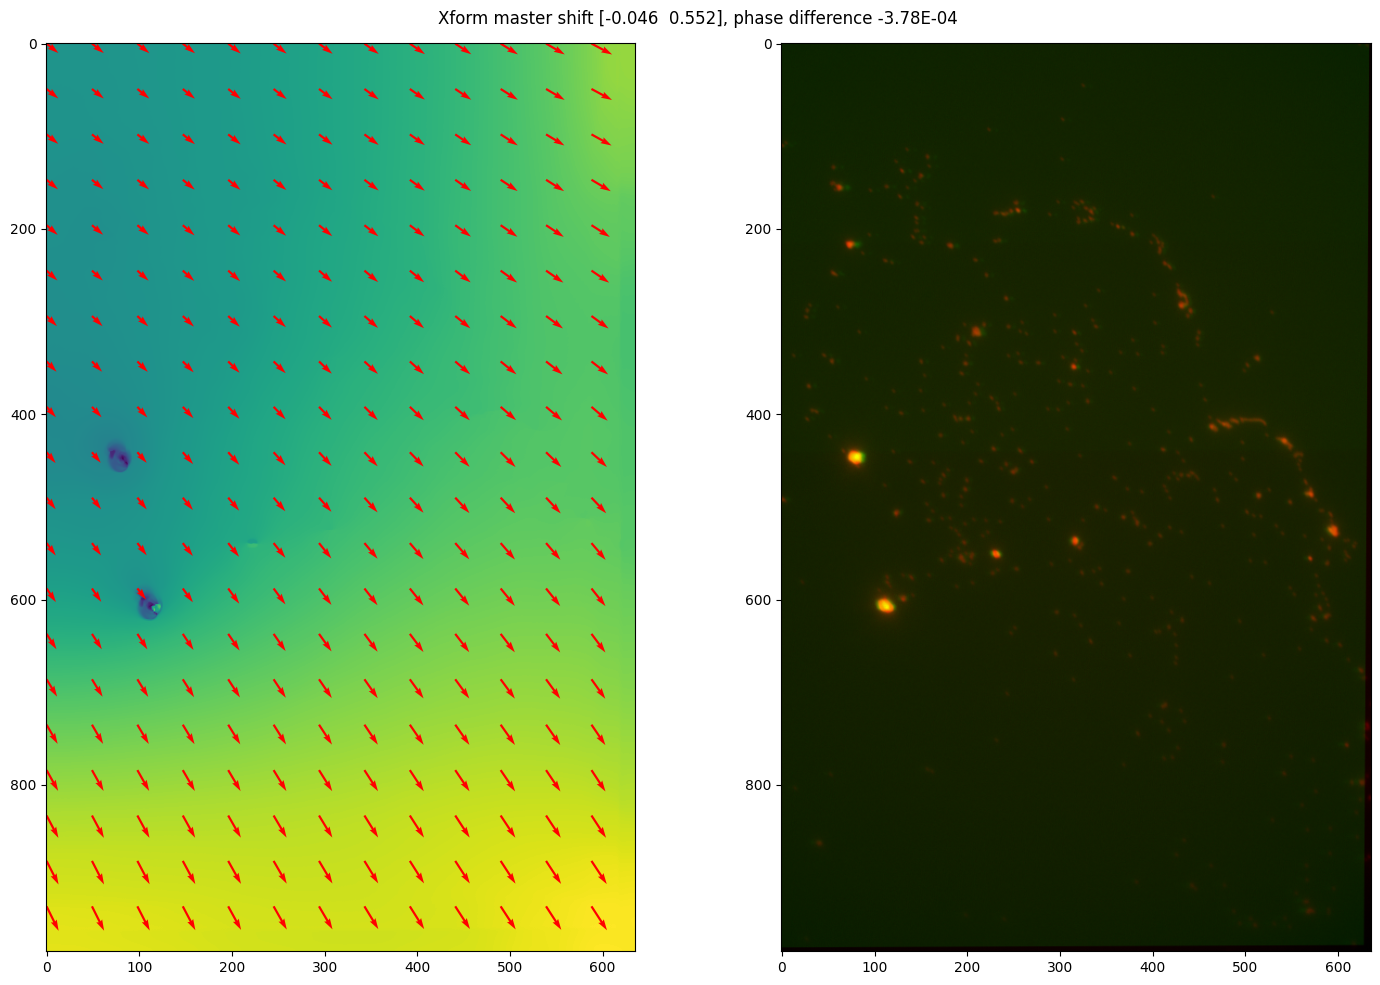

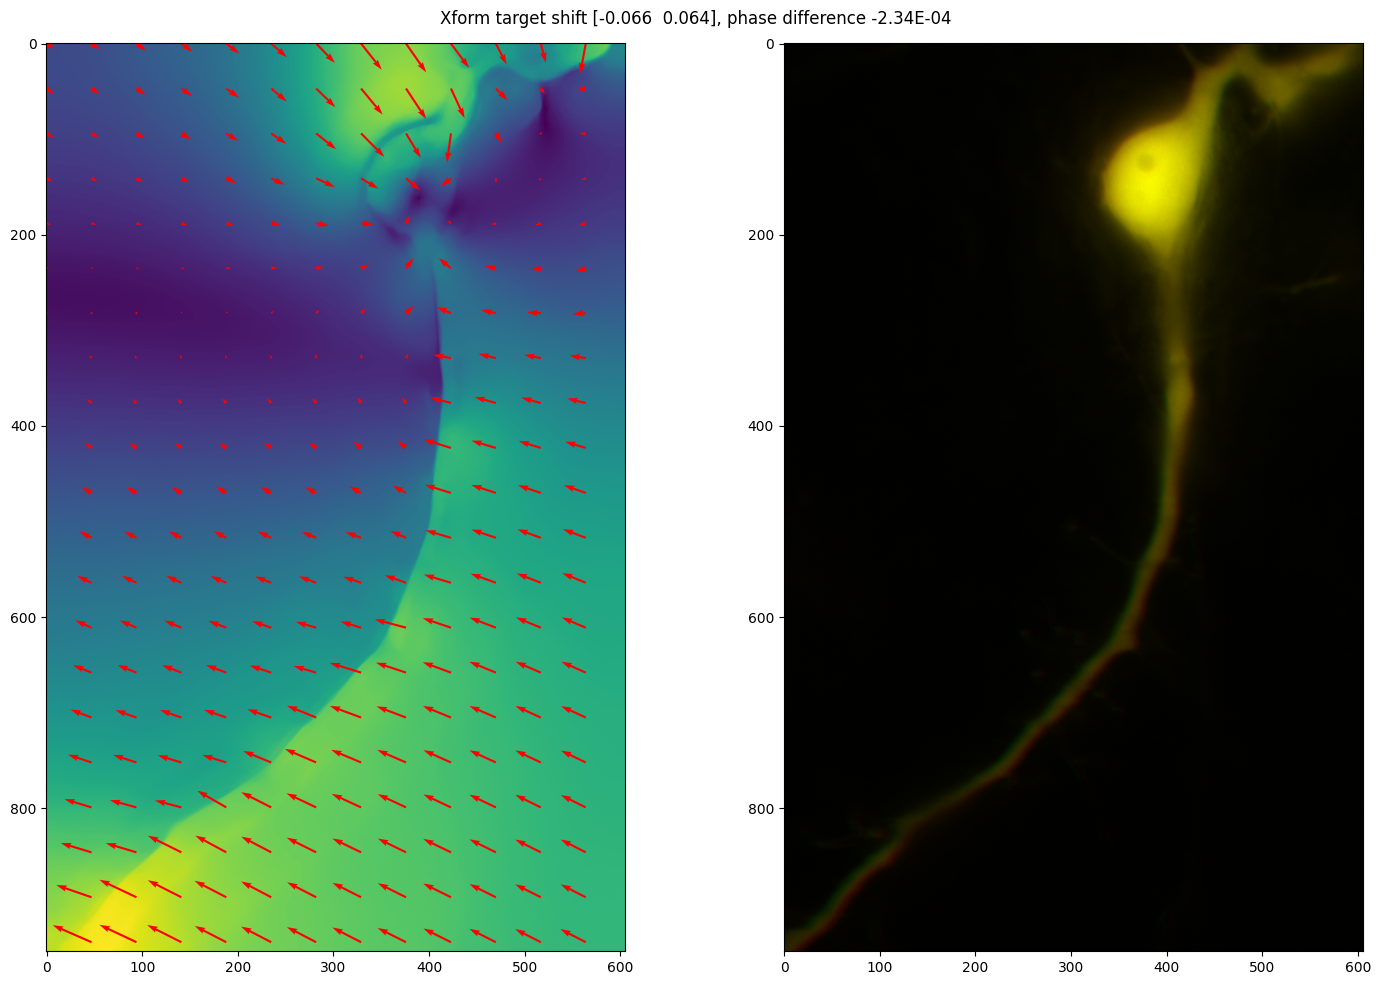

In [9]:
_,_ = masking.registration_by_beads(master_ref=master_ref, master_offset=master_offset,
                                    target_ref=demo_ref, target_offset=demo_offset,
                                    border_crop=30, output_crop=15, show_misalign=True)

In [ ]:
affreg = AffineRegistration()
transform = AffineTransform2D()
affine = affreg.optimize(master_ref, master_offset, transform, params0=None)

In [ ]:
master_offset_xform = affine.transform(master_offset)
demo_offset_xform = affine.transform(demo_offset)

# misalign_estimate(master_ref, master_offset_xform, title='Master xform')
misalign_estimate(demo_ref, demo_offset_xform, title='Demo xform')

#### Optical flow

In [ ]:
def flow_restoration(raw_ref_img, raw_offset_img):
    ref_img = filters.sobel_h(raw_ref_img)
    offset_img = filters.sobel_h(raw_offset_img)
    input_shift, input_error, input_diffphase = phase_cross_correlation(ref_img, offset_img, upsample_factor=1000)
    v, u = optical_flow_tvl1(ref_img, offset_img)
    nr, nc = ref_img.shape
    r_coord, c_coord = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
    flow_warp_matrix = np.array([r_coord + v, c_coord + u])
    flow_warp_img = transform.warp(raw_offset_img, flow_warp_matrix, mode='edge', order=5)
    output_shift, output_error, output_diffphase = phase_cross_correlation(raw_ref_img, flow_warp_img, upsample_factor=1000)
    print(f'Flow restoration: input shift={input_shift}, outputshift={output_shift}')
    return flow_warp_img

flow_warp_img = flow_restoration(ref_img, offset_img)

## OpenCV

In [ ]:
def Gradient(Image) :
    # Calculate the x and y gradients using Sobel operator
    grad_x = filters.sobel_h(Image)
    grad_y = filters.sobel_v(Image)
    # Combine the two gradients
    grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)
    return grad.astype('float32')

Image1 = ref_img
Image2 = offset_img
algn_scale = 1
    
Temp1 = cv2.resize(Image1, dsize=(0, 0),
                    fx=algn_scale, fy=algn_scale,
                    interpolation = cv2.INTER_LANCZOS4)
Temp2 = cv2.resize(Image2, dsize=(0, 0), 
                    fx=algn_scale, fy=algn_scale,
                    interpolation = cv2.INTER_LANCZOS4)


print(Image1.shape)
print(Temp1.shape)

warp_mode = cv2.MOTION_AFFINE
WarpMatrix = np.eye(2, 3, dtype='float32')
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)
(cc, WarpMatrix) = cv2.findTransformECC(Gradient(Temp1), Gradient(Temp2), WarpMatrix, warp_mode, criteria)
WarpMatrix[:, 2] = WarpMatrix[:, 2] / algn_scale

print(WarpMatrix)


In [ ]:
def cv_warp(Image2, WarpMatrix):
    warp_img = cv2.warpAffine(Image2, WarpMatrix, Image2.shape[::-1], flags=cv2.INTER_LANCZOS4 + cv2.WARP_INVERSE_MAP)
    return warp_img
# warp_img_cv2 = transform.warp(offset_img, WarpMatrix, order=5)

ecc_warp_img = cv_warp(offset_img, WarpMatrix)

shift, error, diffphase = phase_cross_correlation(ref_img, offset_img, upsample_factor=1000)
print(shift, error, diffphase)

shift, error, diffphase = phase_cross_correlation(ref_img, ecc_warp_img, upsample_factor=1000)
print(shift, error, diffphase)

## Algn comparison with flow

In [ ]:
def misalign_estimate(img1, img2, title:str=''):
    v, u = optical_flow_tvl1(img1, img2)
    norm = np.sqrt(u ** 2 + v ** 2)

    nvec = 20  # Number of vectors to be displayed along each image dimension
    nl, nc = ref_img.shape
    step = max(nl//nvec, nc//nvec)

    y, x = np.mgrid[:nl:step, :nc:step]
    u_ = u[::step, ::step]
    v_ = v[::step, ::step]

    print(phase_cross_correlation(img1, img2, upsample_factor=5000))

    plt.figure(figsize=(8, 8))
    plt.imshow(norm)
    plt.quiver(x, y, u_, v_, color='r', units='dots',
            angles='xy', scale_units='xy', lw=3)
    plt.title(title)
    plt.show()

In [ ]:
misalign_estimate(ref_img, offset_img, title='Raw')

misalign_estimate(ref_img, flow_warp_img, title='Flow')

misalign_estimate(ref_img, phase_warp_img, title='Phase')

misalign_estimate(ref_img, ecc_warp_img, title='CV')

## Restore by matrix

In [ ]:
def phase_restoration(raw_ref_img, raw_offset_img):
    ref_img = filters.sobel_h(raw_ref_img)
    offset_img = filters.sobel_h(raw_offset_img)
    input_shift, input_error, input_diffphase = phase_cross_correlation(ref_img, offset_img, upsample_factor=1000)
    tform = transform.SimilarityTransform(translation=(-input_shift[1], -input_shift[0]))
    phase_warp_img = transform.warp(raw_offset_img, tform, order=5)
    output_shift, output_error, output_diffphase = phase_cross_correlation(raw_ref_img, phase_warp_img, upsample_factor=1000)
    print(f'Phase restoration: input shift={input_shift}, outputshift={output_shift}')
    return phase_warp_img, tform

phase_warp_img, phase_matrix = phase_restoration(ref_img, offset_img)

demo_restore = transform.warp(demo_offset, phase_matrix, order=5)

misalign_estimate(demo_ref, demo_offset, title='Raw demo')
misalign_estimate(demo_ref, demo_restore, title='Restore demo')


## Restore with DiPy

In [ ]:
# https://neuroimaging-data-science.org/content/006-image/003-registration.html

# Bin

In [36]:
raw_img = io.imread('/home/wisstock/bio_data/chemLTD/Sasha/24_05_09/25_05_09_sasha_merged/24_05_9_cell01.tif')
raw_img.shape

FileNotFoundError: [Errno 2] No such file or directory: '/home/wisstock/bio_data/chemLTD/Sasha/24_05_09/25_05_09_sasha_merged/24_05_9_cell01.tif'

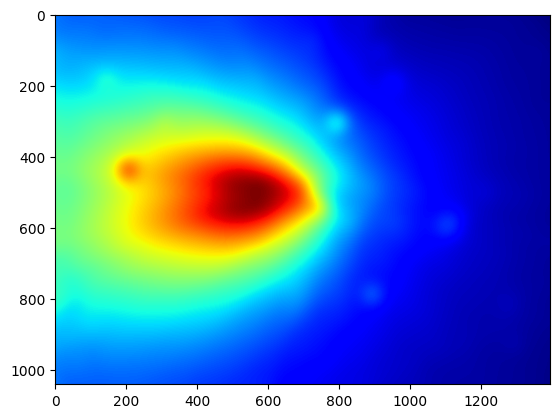

In [59]:
alexa_avg_max_img = raw_img[200,1,...]
alexa_filtered = filters.gaussian(alexa_avg_max_img, sigma=25)
alexa_norm = (alexa_filtered - np.min(alexa_filtered)) / (np.max(alexa_filtered) - np.min(alexa_filtered))

alexa_bin = np.digitize(alexa_norm, bins=[0.0, 0.25, 0.50, 0.75, 1.0])

plt.imshow(alexa_bin, cmap='jet', vmin=0, vmax=1)

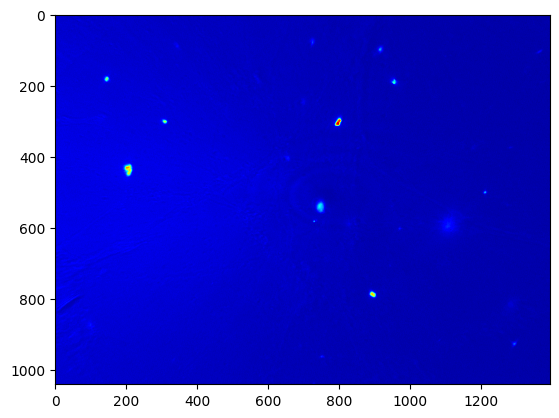

In [24]:
plt.imshow(raw_img[1,1,...], cmap='jet')

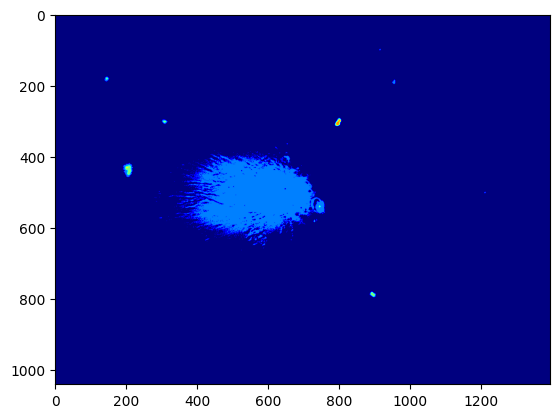

In [20]:
alexa_bin = np.digitize(alexa_norm, bins=[0.0, 0.25, 0.50, 0.75, 1.0])
plt.imshow(alexa_bin, cmap='jet')